# `GroupedPipeline`: applying a transformer per category

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

from timeserio.data.datasets import load_iris_df
from timeserio.pipeline import GroupedPipeline
from timeserio.preprocessing import PandasValueSelector

import seaborn as sns

## Load the iris dataset

This dataset consists of four numeric and one categorical columns.

In [2]:
df = load_iris_df()
df.head(2)

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa


Imagine we want to predict `sepal_width_cm` based on `sepal_length_cm`: we may try fitting a simple linear regression model. The result is somewhat unsatisfying:

## Fit a joint model

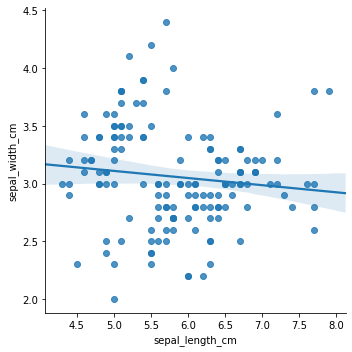

In [3]:
sns.lmplot(x="sepal_length_cm", y="sepal_width_cm", data=df)

In `sklearn`, we can represent the model (in this case, a linear regression on selected features) as a pipeline:

In [4]:
simple_model = Pipeline([
    ("features", PandasValueSelector("sepal_length_cm")),
    ("lr", LinearRegression()),
])

In [5]:
simple_model.fit(df, df["sepal_width_cm"])

Pipeline(memory=None,
     steps=[('features', PandasValueSelector(columns='sepal_length_cm')), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [6]:
y_pred, y = simple_model.predict(df), df["sepal_width_cm"]
print(f"MSE = {mse(y, y_pred)}, MAE = {mae(y, y_pred)}")

MSE = 0.18610437589381357, MAE = 0.33122352979559877


In [7]:
lr = simple_model.named_steps['lr']
print(f"Intercept: {lr.intercept_:.2f}, slope: {lr.coef_[0]:.2f}")

Intercept: 3.42, slope: -0.06


## Fit a model per category

We can improve the regression model signiifcantly  by adding the categorical feature `species` - we could try on-hot encoding, embeddings, etc. However, a common approach would be to fit a separate regression model *per category*:

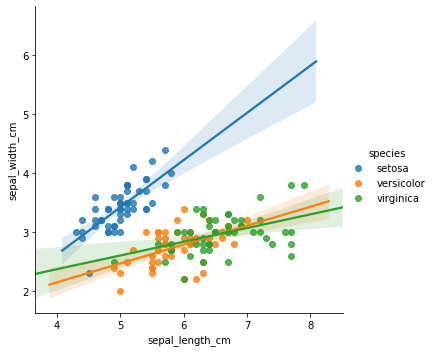

In [8]:
sns.lmplot(x="sepal_length_cm", y="sepal_width_cm", hue="species", data=df)

In [9]:
grouped_model = GroupedPipeline(
    groupby="species",
    pipeline=simple_model
)

In [10]:
grouped_model.fit(df, df["sepal_width_cm"])

# Specifying target by column name is also supported:
grouped_model.fit(df, "sepal_width_cm")

GroupedPipeline(errors='raise', groupby='species',
        pipeline=Pipeline(memory=None,
     steps=[('features', PandasValueSelector(columns='sepal_length_cm')), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]))

In [11]:
y_pred, y = grouped_model.predict(df), df["sepal_width_cm"]
print(f"MSE = {mse(y, y_pred)}, MAE = {mae(y, y_pred)}")

MSE = 0.07119979049915942, MAE = 0.20655162210804365


In [12]:
for group, pipe in grouped_model.pipelines_.items():
    lr = pipe.named_steps['lr']
    print(f"{group}: intercept: {lr.intercept_:.2f}, slope: {lr.coef_[0]:.2f}")

setosa: intercept: -0.57, slope: 0.80
versicolor: intercept: 0.87, slope: 0.32
virginica: intercept: 1.45, slope: 0.23
